In [1]:
import numpy as np
import cv2
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import pickle
import defs
from tqdm import tqdm
from multiprocessing import Pool
from pathlib import Path
from shutil import unpack_archive,rmtree
import requests

In [2]:
def file_exists(path):
    file = Path(path)
    return file.is_file()

def downloadfile(url,output):
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(output, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")
dataseturl = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
datasetfilename = "lfw.tgz"
if not file_exists(datasetfilename):
    downloadfile(dataseturl, datasetfilename)
else:
    print("Dataset exists already")

Dataset exists already


In [3]:
try:
    rmtree('lfw')
except:
    pass
unpack_archive(datasetfilename, "lfw")

In [4]:
autoencoder = load_model('model')

In [5]:
face_images = glob.glob('lfw/lfw/**/*.jpg') #returns path of images
print(len(face_images)) #contains 13243 images

13233


In [6]:
def save_image_array():
    with open('img_array.pickle','wb') as f:
      pickle.dump(img_array, f)
    return img_array
def load_image_array():
    with open('img_array.pickle','rb') as f:
        image_array = pickle.load(f)
    return image_array

if not file_exists('img_array.pickle'):
    p = Pool(12)
    with Pool(12) as p:
        img_array = list(tqdm(p.imap(defs.read, face_images), total=len(face_images),position=0))
    save_image_array()
else:
    img_array = load_image_array()

In [7]:
all_images = np.array(img_array)
#Split test and train data. all_images will be our output images
train_x, val_x = train_test_split(all_images, random_state = 32, test_size=0.2)

In [8]:
#now we will make input images by lowering resolution without changing the size
def pixalate_image(image, scale_percent = 40):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    # scale back to original size
    width = int(small_image.shape[1] * 100 / scale_percent)
    height = int(small_image.shape[0] * 100 / scale_percent)
    dim = (width, height)
    low_res_image = cv2.resize(small_image, dim, interpolation =  cv2.INTER_AREA)
    return low_res_image

In [9]:
train_x_px = []
for i in range(train_x.shape[0]):
    temp = pixalate_image(train_x[i,:,:,:])
    train_x_px.append(temp)
train_x_px = np.array(train_x_px)   #Distorted images
# get low resolution images for the validation set
val_x_px = []
for i in range(val_x.shape[0]):
    temp = pixalate_image(val_x[i,:,:,:])
    val_x_px.append(temp)
val_x_px = np.array(val_x_px)     #Distorted images

In [10]:
results = autoencoder.evaluate(val_x_px, val_x)
print('val_loss, val_accuracy', results)

83/83 [==============================] - 58s 673ms/step - loss: 0.0021 - accuracy: 0.9232
val_loss, val_accuracy [0.0021336209028959274, 0.9232476353645325]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


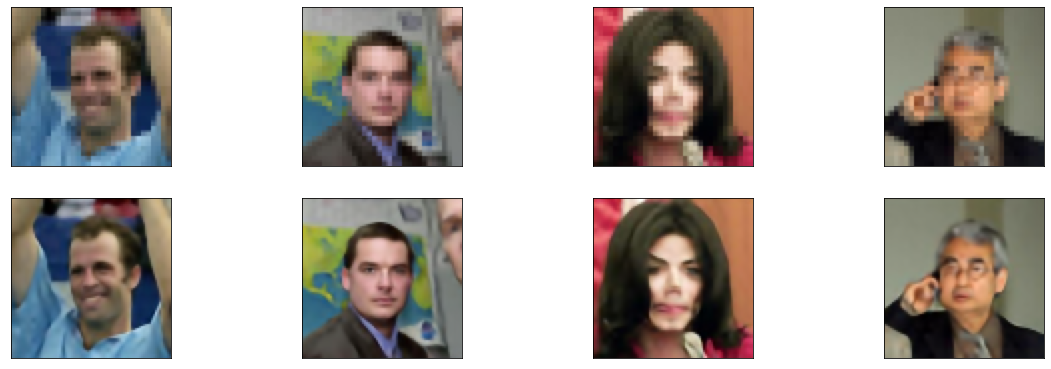

In [11]:
predictions = autoencoder.predict(val_x_px)
n = 4
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+20])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()